In [1]:
import gmsh
import numpy as np
from importlib.machinery import SourceFileLoader

el metodo initialize 'abre' el programa.

In [2]:
gmsh.initialize()

Info    : Increasing process stack size (8192 kB < 16 MB)


'armamos' el modelo que queremos modificar:

In [3]:
modelname = 'chapa_agujero'

In [4]:
gmsh.model.add(modelname)

In [5]:
lc = 1
R = 1   # radio del agujero
Long = 10

Definimos las coordenadas de los puntos

In [6]:
P  = [
     gmsh.model.geo.addPoint(0, 0, 0, lc/10), #0
     gmsh.model.geo.addPoint(-Long, -Long/2, 0, lc), #1
     gmsh.model.geo.addPoint(0, -Long/2, 0, 2*lc/3), #2
     gmsh.model.geo.addPoint(Long, -Long/2, 0, lc), #3
     gmsh.model.geo.addPoint(Long, 0, 0, lc), #4
     gmsh.model.geo.addPoint(Long, Long/2, 0, lc), #5
     gmsh.model.geo.addPoint(0, Long/2, 0, 2*lc/3), #6
     gmsh.model.geo.addPoint(-Long, Long/2, 0, lc), #7
     gmsh.model.geo.addPoint(-Long, 0, 0, lc), #8
     gmsh.model.geo.addPoint(R, 0, 0, lc/3), #9
     gmsh.model.geo.addPoint(0, R, 0, lc/3), #10
     gmsh.model.geo.addPoint(-R, 0, 0, lc/3), #11
     gmsh.model.geo.addPoint(0, -R, 0, lc/3), #12
]

Luego definimos las lineas

In [7]:
L = [ 
 gmsh.model.geo.addLine(P[1],P[2]), #0
 gmsh.model.geo.addLine(P[2],P[3]), #1
 gmsh.model.geo.addLine(P[3],P[4]), #2
 gmsh.model.geo.addLine(P[4],P[5]), #3
 gmsh.model.geo.addLine(P[5],P[6]), #4
 gmsh.model.geo.addLine(P[6],P[7]), #5
 gmsh.model.geo.addLine(P[7],P[8]), #6
 gmsh.model.geo.addLine(P[8],P[1]), #7
 gmsh.model.geo.addCircleArc(P[9],P[0],P[10]), #8
 gmsh.model.geo.addCircleArc(P[10],P[0],P[11]), #9
 gmsh.model.geo.addCircleArc(P[11],P[0],P[12]), #10
 gmsh.model.geo.addCircleArc(P[12],P[0],P[9]), #11
]

In [8]:
Ejesx = [
    gmsh.model.geo.addLine(P[8], P[11]), 
    gmsh.model.geo.addLine(P[4], P[9]),
]
Ejesy = [
    gmsh.model.geo.addLine(P[2], P[12]),
    gmsh.model.geo.addLine(P[6], P[10]),
]

Las curvas nos van a servir para definir los bordes de nuestro modelo.

In [9]:
C1 = gmsh.model.geo.addCurveLoop(L)

Info    : Starting subloop 1 in Curve Loop 1 (are you sure about this?)


Y las superficies:

In [10]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

le avisamos que ya estan todos los elementos geométricos:

In [11]:
gmsh.model.geo.synchronize()

In [12]:
gmsh.model.mesh.embed(1, Ejesx+Ejesy, 2, S1)

In [14]:
traccionadas = np.array([L[2], L[3], L[6], L[7]])

In [15]:
[L[l] for l in traccionadas]

[4, 5, 8, 9]

In [16]:
EmpotradoX = gmsh.model.addPhysicalGroup(1, Ejesx)
gmsh.model.setPhysicalName(1,EmpotradoX,'EmpotradoX')

EmpotradoY = gmsh.model.addPhysicalGroup(1,Ejesy)
gmsh.model.setPhysicalName(1,EmpotradoY,'Empotradoy')

Traccionado = gmsh.model.addPhysicalGroup(1, [L[2], L[3], L[6], L[7]])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

In [17]:
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Circle)
Info    : [ 60%] Meshing curve 10 (Circle)
Info    : [ 70%] Meshing curve 11 (Circle)
Info    : [ 70%] Meshing curve 12 (Circle)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (Line)
Info    : [100%] Meshing curve 16 (Line)
Info    : Done meshing 1D (Wall 0.00555031s, CPU 0.007536s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0149403s, CPU 0.014154s)
Info    : 677 nodes 1413 elements


# El objeto mesh

El mallado es un objeto del cual podemos recuperar la información necesaria para interactuar con nuestro motor de elementos finitos. Por ejemplo para la informacion de los nodos:

In [19]:
NodeInfo = gmsh.model.mesh.get_nodes_for_physical_group(2,Superficie)

NumeroNodos = NodeInfo[0].shape[0]

MN = NodeInfo[1].reshape(NumeroNodos , 3)

## Elementos

Podemos ser un poco más precabios y tomar solo los triángulos, que son los que nos interesan para la guía 

In [20]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

la matriz de conectividad también hay que reformatear para tener lo que estamos acostumbrados.

In [21]:
MC = ELEMENTS.reshape([ETAGS.shape[0],3])

In [22]:
ELEMENTS.shape

(3780,)

# Condiciones de contorno

Con las definiciones de los Physical Groups, podemos sacar los índices de los nodos que estan empotrados o traccionados. Necesitamos definir una 'entidad' para los elements Traccionados:

In [23]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Ltraccionadas = []
for entitityt in entityTraccionada:
    thisTgroup, thisTtraccionada, thisLtraccionada = gmsh.model.mesh.get_elements(1, entitityt)
    Ltraccionadas.append(thisLtraccionada[0].reshape(thisTtraccionada[0].shape[0],2))
Ltraccionadas = np.vstack(Ltraccionadas)
#Ltraccionada = Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2)

Con los elementos líneas traccionadas podemos calcular las longitudes y distribuir la fuerza externa. 

In [24]:
Longitudes = np.abs( MN[Ltraccionadas[:,0]-1,1] - MN[Ltraccionadas[:,1]-1,1] )

Ahora puedo calcular las fuerzas:

In [25]:
Longitudes

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [26]:
len(Longitudes)

20

In [27]:
Fuerzas = np.zeros((2*NumeroNodos,1))
espesor = 1
tension = 1000 #Pa

for l, linea in enumerate(Ltraccionadas):
    Flocal = np.array([[1],[1]])*tension*espesor*Longitudes[l]/2
    n1 = linea[0]
    n2 = linea[1]
    sign = MN[int(n1-1),0]/abs(MN[int(n1-1),0])
    #print(Flocal)
    Fuerzas[ np.array([2*(n1-1), 2*(n2-1)], dtype=int)] += sign*Flocal
Desplazamientos = np.zeros((2*NumeroNodos,1))

Exy = np.hstack( (Fuerzas.reshape(NumeroNodos, 2) , np.zeros((NumeroNodos, 1))) )

In [28]:
fext = gmsh.view.add('FuerzasExternas')
Fext = gmsh.view.addModelData(fext,0,modelname,'NodeData',NodeInfo[0],Exy)
gmsh.option.setNumber(f'View[{fext}].VectorType',4)

# Empotrados

Para definir los nodos empotrados necesito solamente los índices de los nodos en dicho physical group

In [29]:
NodosEmpotradosX = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoX)
NodosEmpotradosY = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoY)

Con eso ya puedo calcular los valores de los índices de los nodos que resultarán empotrados.

In [30]:
s = []
for n, nodo in enumerate(NodosEmpotradosX[0]-1):
    s.append(
        2*(nodo)+1
    )
for n, nodo in enumerate(NodosEmpotradosY[0]-1):
    s.append(
        2*(nodo)
    )

s = np.array(s).astype(int).ravel()
r = np.linspace(0, 2*(NumeroNodos-1)+1, 2*NumeroNodos).astype(int)
r = np.delete( r, s )

In [31]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.8.4
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20210428
Build host    : gmsh.info
Build options : 64Bit ALGLIB ANN Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen Fltk Gmm Hxt Jpeg[fltk] Kbipack Lapack[petsc] LinuxJoystick MathEx Med Mesh Metis Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OptHom PETSc Parser Plugins Png[fltk] Post QuadTri Solver TetGen/BR Voro++ Zlib[fltk]
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


# Agregar Resulatados

In [32]:
# import mefmods as mef
mef = SourceFileLoader('mef','mefmods.py').load_module()

In [33]:
ETYPES = 2*np.ones(len(MC)).astype(int)

nu = 0.3

E = 210E9

MP = np.hstack(
        (
            np.ones((len(MC), 1)),
            np.ones((len(MC), 1))*nu,
            np.ones((len(MC), 1))*E
            )
        )

K = mef.ensamble(MC-1, MN, MP, 2, ETYPES, 'Chapa-Asimetrica-2021')

s.sort()

#Desplazamientos[r] = 
Desplazamientos, FResultado = mef.resolvermef(r,s,K,Desplazamientos[s], Fuerzas[r], 'Chapa-Asimetrica-2021')

# import mefmods as mef
mef = SourceFileLoader('mef','mefmods.py').load_module()
sigma = mef.getstress2(MC, ETYPES, MP, MN, Desplazamientos)

SA = 0.5*(sigma[:,0]+sigma[:,1])
SB = np.sqrt(SA**2+ sigma[:,2]**2)
SIGMA_MAX = SA+SB
SIGMA_MIN = SA-SB

Rxy = np.hstack( (FResultado.reshape(NumeroNodos, 2) , np.zeros((NumeroNodos, 1))) )

Dxy = np.hstack( (Desplazamientos.reshape(NumeroNodos, 2) , np.zeros((NumeroNodos, 1))) )

SIGMA_AVE_MAX = np.zeros([NumeroNodos,1])

SIGMA_AVE_MIN = np.zeros([NumeroNodos,1])

for node in range(NumeroNodos):
    SIGMA_AVE_MAX[node] = SIGMA_MAX[ ETAGS[ (MC == node+1).any(axis=1) ] - ETAGS.min() ].mean()

for node in range(NumeroNodos):
    SIGMA_AVE_MIN[node] = SIGMA_MIN[ ETAGS[ (MC == node+1).any(axis=1) ] - ETAGS.min() ].mean()

# Guardo los resultados 

In [34]:
despview = gmsh.view.add('Desplazamientos')
Desp = gmsh.view.addModelData(despview,0,modelname,'NodeData',NodeInfo[0],Dxy)
gmsh.option.setNumber(f'View[{despview}].VectorType',5)

forview = gmsh.view.add('Fuerzas')
Fza = gmsh.view.addModelData(forview,0,modelname,'NodeData',NodeInfo[0], Rxy)
gmsh.option.setNumber(f'View[{forview}].VectorType',4)

tenmaxview = gmsh.view.add('Tension Maxima')
tenmax = gmsh.view.addModelData(tenmaxview,0,modelname,'ElementData',ETAGS, SIGMA_MAX.reshape(-1,1))

tenminview = gmsh.view.add('Tension Mínima')
tenmax = gmsh.view.addModelData(tenminview,0,modelname,'ElementData',ETAGS, SIGMA_MIN.reshape(-1,1))

tenxview = gmsh.view.add('Sigma_x')
tenx = gmsh.view.addModelData(tenxview,0,modelname,'ElementData',ETAGS, sigma[:,0].reshape(-1,1))

tenyview = gmsh.view.add('Sigma_y')
teny = gmsh.view.addModelData(tenyview,0,modelname,'ElementData',ETAGS, sigma[:,1].reshape(-1,1))

tencorte = gmsh.view.add('Tau_xy')
tenc = gmsh.view.addModelData(tencorte, 0,modelname,'ElementData',ETAGS, sigma[:,2].reshape(-1,1))

tenmaxave = gmsh.view.add('Sigma_max_ave')
tenmave = gmsh.view.addModelData(tenmaxave, 0,modelname,'NodeData',NodeInfo[0], SIGMA_AVE_MAX.reshape(-1,1))

tenminave = gmsh.view.add('Sigma_min_ave')
tenmiave = gmsh.view.addModelData(tenminave, 0,modelname,'NodeData',NodeInfo[0], SIGMA_AVE_MIN.reshape(-1,1))

In [35]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.8.4
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20210428
Build host    : gmsh.info
Build options : 64Bit ALGLIB ANN Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen Fltk Gmm Hxt Jpeg[fltk] Kbipack Lapack[petsc] LinuxJoystick MathEx Med Mesh Metis Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OptHom PETSc Parser Plugins Png[fltk] Post QuadTri Solver TetGen/BR Voro++ Zlib[fltk]
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


In [36]:
gmsh.finalize()

Algunos dibujitos

In [37]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20,10))
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend',  fontsize=20)

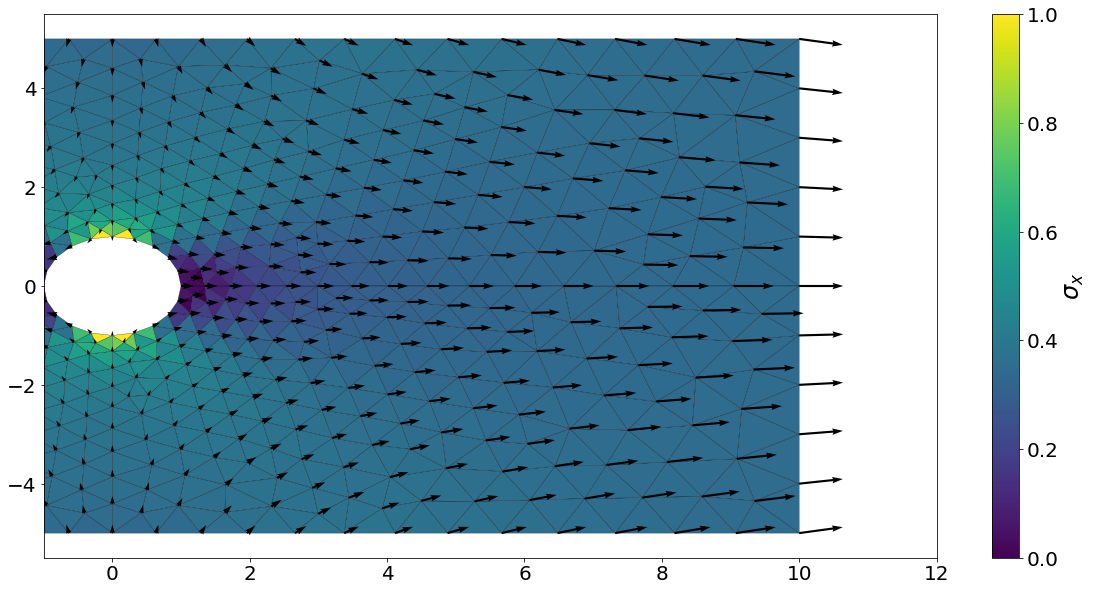

In [40]:
plt.tripcolor(MN[:,0], MN[:,1], MC-MC.min(),edgecolor='k', facecolors=sigma[:,0],label='$\sigma _x$')
plt.quiver(MN[:,0], MN[:,1],Dxy[:,0],Dxy[:,1], units='x')
plt.xlim([-1,10+2])
cbar = plt.colorbar()
cbar.set_label('$\sigma_x$')

In [46]:
C = []
for elem in MC-MC.min():
    C.append(SIGMA_AVE_MAX[elem])
    

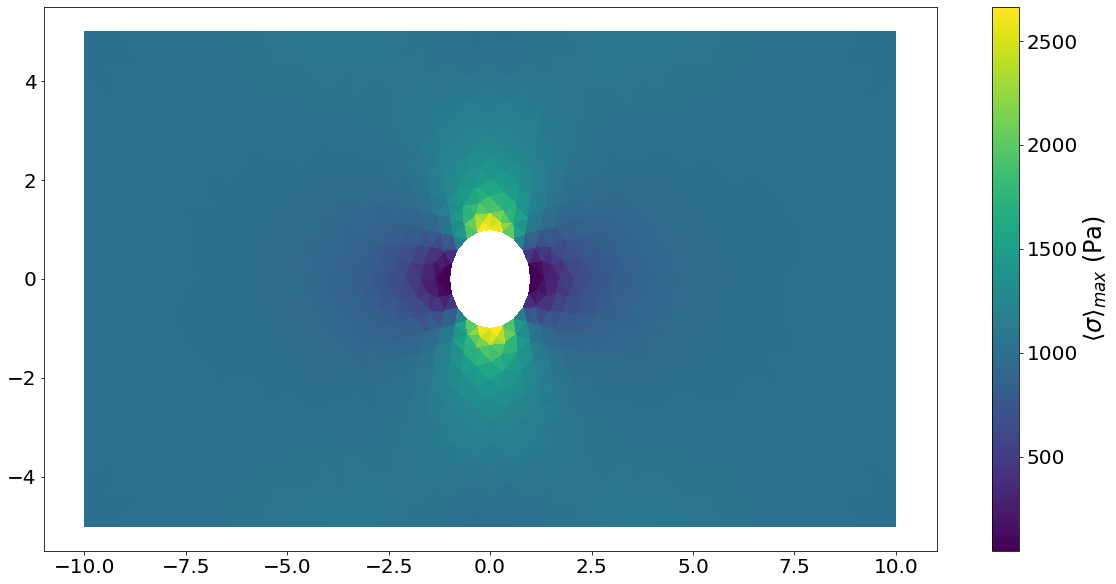

In [57]:
plt.tripcolor(MN[:,0], MN[:,1], MC-MC.min(),SIGMA_AVE_MAX.ravel())
cbar = plt.colorbar()
cbar.set_label(r'$\langle \sigma \rangle _{max}$ (Pa)')

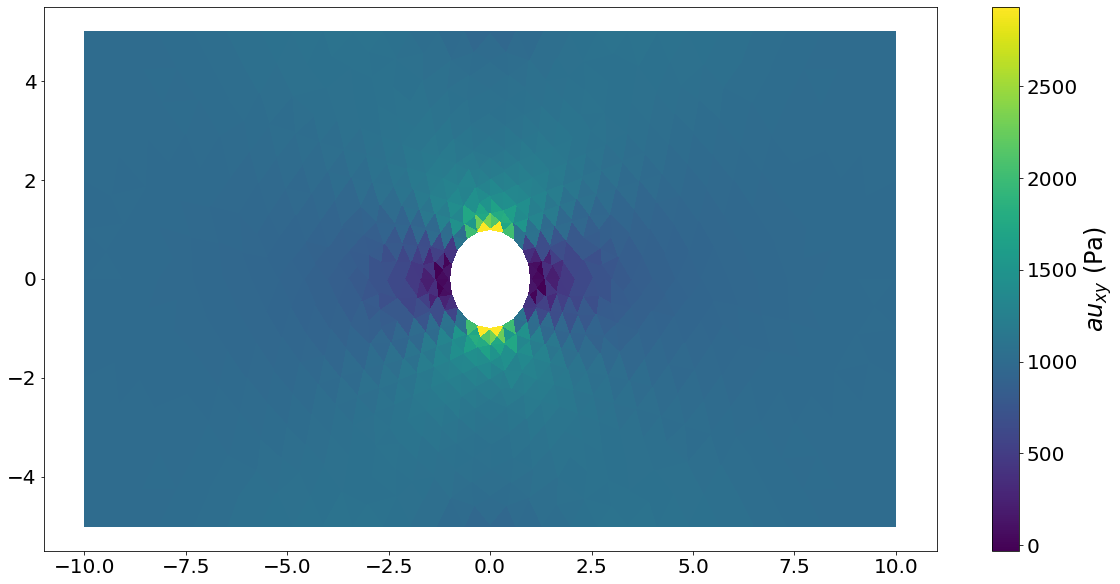

In [44]:
plt.tripcolor(MN[:,0], MN[:,1], MC-MC.min(),facecolors=sigma[:,0])
cbar = plt.colorbar()
cbar.set_label('$\tau_{xy}$ (Pa)')